In [90]:
# List all files in ../input/
import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

/kaggle/input/dataset/.gitkeep
/kaggle/input/dataset/raw/.gitkeep
/kaggle/input/dataset/raw/val/masks/009.png
/kaggle/input/dataset/raw/val/masks/014.png
/kaggle/input/dataset/raw/val/masks/010.png
/kaggle/input/dataset/raw/val/masks/011.png
/kaggle/input/dataset/raw/val/masks/002.png
/kaggle/input/dataset/raw/val/masks/005.png
/kaggle/input/dataset/raw/val/masks/008.png
/kaggle/input/dataset/raw/val/masks/007.png
/kaggle/input/dataset/raw/val/masks/003.png
/kaggle/input/dataset/raw/val/masks/006.png
/kaggle/input/dataset/raw/val/masks/000.png
/kaggle/input/dataset/raw/val/masks/012.png
/kaggle/input/dataset/raw/val/masks/004.png
/kaggle/input/dataset/raw/val/masks/013.png
/kaggle/input/dataset/raw/val/masks/001.png
/kaggle/input/dataset/raw/val/imgs/009.png
/kaggle/input/dataset/raw/val/imgs/014.png
/kaggle/input/dataset/raw/val/imgs/010.png
/kaggle/input/dataset/raw/val/imgs/011.png
/kaggle/input/dataset/raw/val/imgs/002.png
/kaggle/input/dataset/raw/val/imgs/005.png
/kaggle/input/da

In [124]:
# Python STL
import os
import pdb
import time
import warnings
import random
# Image Processing
import cv2
# Data Science
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from sklearn.model_selection import StratifiedKFold
#PyTorch
import torch
import torch.nn as nn
from torch.nn import functional as F
from torch.optim.lr_scheduler import ReduceLROnPlateau
import torch.optim as optim
import torch.backends.cudnn as cudnn
from torch.utils.data import DataLoader, Dataset, sampler
# Fancy progress bars
from tqdm import tqdm_notebook as tqdm
# Data augmentation
from albumentations import (IAAPerspective, ShiftScaleRotate, CLAHE, RandomRotate90, 
                            Transpose, ShiftScaleRotate,Blur, OpticalDistortion, 
                            GridDistortion, HueSaturationValue,
                            IAAAdditiveGaussianNoise, GaussNoise, MotionBlur, MedianBlur, 
                            IAAPiecewiseAffine, IAASharpen, IAAEmboss, RandomBrightnessContrast, 
                            Flip, OneOf, Compose, Normalize, RandomSizedCrop, ElasticTransform, 
                            MultiplicativeNoise, JpegCompression)
# TODO: Move to ToTensorV2
from albumentations.pytorch import ToTensorV2

# Silence warnings
warnings.filterwarnings("ignore")

In [93]:
# Load segmentation_models_pytorch package from pip for pretrained models
!pip install git+https://github.com/qubvel/segmentation_models.pytorch > /dev/null 2>&1 # Install segmentations_models.pytorch, with no bash output.

In [94]:
# For pretrained models
import segmentation_models_pytorch as smp

In [95]:
# Root folder of dataset
# root/
# |___train/
# |___test/
# |___val/
DATA_FOLDER = "../input/dataset/raw/"

Calculating mean and standard deviation for images in the train set

In [108]:
image_names = os.listdir(os.path.join(DATA_FOLDER, "train", "imgs"))
means = np.array([0.0, 0.0, 0.0])
stds = np.array([0.0, 0.0, 0.0])
for image_name in image_names:
    img = cv2.imread(os.path.join(DATA_FOLDER, "train", "imgs", image_name))
    np.add(means, np.array([img[:, :, i].mean() for i in range(3)]), out=means)
    np.add(stds, np.array([img[:, :, i].std() for i in range(3)]), out=stds)
    
means, stds = means/len(image_names), stds/len(image_names)
means, stds

(array([157.21944855, 118.87670799, 170.3663776 ]),
 array([38.04942974, 48.23353389, 45.90285242]))

Calculating mean and standard deviation for masks in the train set

In [109]:
mask_names = os.listdir(os.path.join(DATA_FOLDER, "train", "masks"))
means = np.array([0.0])
stds = np.array([0.0])
for mask_name in mask_names:
    mask = cv2.imread(os.path.join(DATA_FOLDER, "train", "masks", mask_name), cv2.IMREAD_GRAYSCALE)
    mask = np.expand_dims(mask, axis=0)
    np.add(means, np.array([mask[:, :, 0].mean()]), out=means)
    np.add(stds, np.array([mask[:, :, 0].std()]), out=stds)
    
means, stds = means/len(mask_names), stds/len(mask_names)
means, stds, means/255, stds/255

(array([28.10976563]),
 array([59.88283905]),
 array([0.11023438]),
 array([0.23483466]))

In [125]:
class OrganDataset(Dataset):
    # TODO: Try to create a BasicDataset class you can inherit from 
    def __init__(self, data_folder, phase):
        assert os.path.isdir(data_folder), "{} is not a directory or it doesn't exist.".format(data_folder)
        self.root = data_folder
        assert phase in ['train', 'test', 'val'], "Provide any one of train/test/val as phase."
        self.phase = phase
        self.transforms = get_transforms(self.phase)
        # Get names & number of images in root/train or root/val
        _path_to_imgs= os.path.join(self.root, self.phase, "imgs")
        assert os.path.isdir(_path_to_imgs), "{} doesn't exist.".format(_path_to_imgs)
        self.image_names = sorted(os.listdir(_path_to_imgs))
        assert len(self.image_names) !=0, "No images found in {}".format(_path_to_imgs)

    def __getitem__(self, idx):
        # Load image
        image_name = self.image_names[idx]
        image_path = os.path.join(self.root, self.phase, "imgs", image_name)
        image = cv2.imread(image_path)
        assert image.size != 0, "cv2: Unable to load image - {}".format(image_path)
        
        # Load mask
        mask_name = image_name
        mask_path = os.path.join(self.root, self.phase, "masks", mask_name)
        mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE) # <<<< Change: Generalize reading rgb/gray
        assert mask.size !=0, "cv2: Unable to load mask - {}".format(mask_path)
        
        # TODO: Improve this spagetti (ノಠ益ಠ)ノ彡┻━┻
        # Data Augmentation for image and mask
        augmented = self.transforms['aug'](image=image, mask=mask)
        new_image = self.transforms['img_only'](image=augmented['image'])
        new_mask = self.transforms['mask_only'](image=augmented['mask'])
        aug_tensors = self.transforms['final'](image=new_image['image'], mask=new_mask['image'])
        image = aug_tensors['image']
        mask = aug_tensors['mask']
        mask = torch.unsqueeze(mask, dim=0) # For [1, H, W] instead of [H, W]
        return image, mask

    def __len__(self):
        return len(self.image_names)


def get_transforms(phase):
    """Get composed albumentations transforms"""
    # TODO: Make it easier to add augmentations
    # TODO: Add logging here
    # TODO: Move into DataSet as static method
    aug_transforms = []

    if phase == "train":
        # Data augmentation for training only
        aug_transforms.extend([
            ShiftScaleRotate(
                shift_limit=0,
                scale_limit=0.1,
                rotate_limit=15,
                p=0.5),
            Flip(p=0.5),
            RandomRotate90(p=0.5),
        ])
        # Exotic Augmentations for train only 🤤
        aug_transforms.extend([
            RandomBrightnessContrast(p=0.5),
            ElasticTransform(p=0.5),
            MultiplicativeNoise(multiplier=[0.5, 1.5], per_channel=True, p=0.2),
            JpegCompression(quality_lower=95, quality_upper=100, p=0.4),
            Blur(blur_limit=7, p=0.3),
#             RandomGridShuffle(grid=(3, 3), p=0.2)
        ])
    aug_transforms.extend([
        RandomSizedCrop(min_max_height=(256, 256),
                height=256,
                width=256,
                w2h_ratio=1.0,
                interpolation=cv2.INTER_LINEAR,
                p=1.0),
    ])
    aug_transforms = Compose(aug_transforms)
    
    mask_only_transforms = Compose([
        Normalize(mean=0, std=1, always_apply=True)
    ])
    image_only_transforms = Compose([
        Normalize(mean=(0.0, 0.0, 0.0), std=(1.0, 1.0, 1.0), always_apply=True)
    ])
    final_transforms = Compose([
            ToTensorV2()
    ])
    
    transforms = {
        'aug': aug_transforms,
        'img_only': image_only_transforms,
        'mask_only': mask_only_transforms,
        'final': final_transforms
    }
    return transforms


def provider(data_folder, phase, batch_size=8, num_workers=4):
    """Return DataLoader for the Dataset"""
    # TODO: Add logging here
    # Create dataset
    image_dataset = OrganDataset(data_folder, phase)
    # Create loader
    dataloader = DataLoader(
        image_dataset,
        batch_size=batch_size,
        num_workers=num_workers,
        pin_memory=True,
        shuffle=True,
    )

    return dataloader

DataLoader sanity check

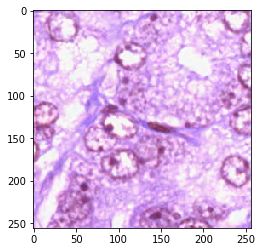

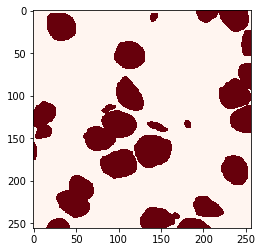

Max: imgs: 1.0000 masks: 1.0000
Min: imgs: 0.1569 masks: 0.0000
Type: imgs: torch.FloatTensor masks: torch.FloatTensor
Shape: imgs: torch.Size([1, 3, 256, 256]) masks: torch.Size([1, 1, 256, 256])
Unique numbers in masks: tensor([0., 1.], device='cpu')


In [113]:
example_loader = provider(
    data_folder=DATA_FOLDER,
    phase="val",
    batch_size=1,
    num_workers=0,
)

e_imgs, e_masks = next(iter(example_loader))
plt.imshow(e_imgs[0].permute([1, 2, 0]))
plt.show()
plt.imshow(e_masks[0][0], cmap='Reds')
plt.show()
print("Max: imgs: {0:.04f} masks: {1:.04f}"
      .format(e_imgs.max(), e_masks.max()))
print("Min: imgs: {0:.04f} masks: {1:.04f}"
     .format(e_imgs.min(), e_masks.min()))
print("Type: imgs: {} masks: {}"
      .format(e_imgs.type(), e_masks.type()))
print("Shape: imgs: {} masks: {}"
     .format(e_imgs.shape, e_masks.shape))
print("Unique numbers in masks: {}".format(e_masks[0].unique()))

In [114]:
def dice_loss(input, target):
    input = torch.sigmoid(input)
    smooth = 1e-7 # <<<<<<<<<<<<< Note: Hardcoded smoothing
    iflat = input.view(-1)
    tflat = target.view(-1)
    intersection = (iflat * tflat).sum()
    return ((2.0 * intersection + smooth) / (iflat.sum() + tflat.sum() + smooth))


class FocalLoss(nn.Module):
    # See: https://arxiv.org/abs/1708.02002
    def __init__(self, gamma):
        super().__init__()
        self.gamma = gamma

    def forward(self, input, target):
        if not (target.size() == input.size()):
            raise ValueError("Target size ({}) must be the same as input size ({})"
                             .format(target.size(), input.size()))
        max_val = (-input).clamp(min=0)
        loss = input - input * target + max_val + \
            ((-max_val).exp() + (-input - max_val).exp()).log()
        invprobs = F.logsigmoid(-input * (target * 2.0 - 1.0))
        loss = (invprobs * self.gamma).exp() * loss
        return loss.mean()

    
# Custom loss function combining Focal loss and Dice loss
class MixedLoss(nn.Module):
    def __init__(self, alpha, gamma):
        super().__init__()
        self.alpha = alpha
        self.focal = FocalLoss(gamma)

    def forward(self, input, target):
        loss = self.alpha*self.focal(input, target) - torch.log(dice_loss(input, target))
        return loss.mean()

In [115]:
# TODO: Move this into Metric
def predict(X, threshold):
    """Thresholding X for binary prediction"""
    X_p = np.copy(X)
    preds = (X_p > threshold).astype('uint8')
    return preds


# TODO: Move this into Metric
def metric(probability, truth, threshold=0.5, reduction='none'):
    """Calculates dice of positive and negative images seperately
       probability and truth must be torch tensors"""
    
    batch_size = len(truth)
    with torch.no_grad():
        # Shape [N, C, H, W]
        probability = probability.view(batch_size, -1)
        truth = truth.view(batch_size, -1)
        # Shape: [N, C*H*W]
        assert (probability.shape == truth.shape), "Shape of prob and truth in fn():metric are not same"

        # Only 1's and 0's in p & t
        p = (probability > threshold).float()
        t = (truth > 0.5).float() # <<<< Change: Hardcoded threshold for ground-truth

        # Shape: [N, C*H*W]
        t_sum = t.sum(-1)
        p_sum = p.sum(-1)
        # Shape: [N, 1]
        neg_index = torch.nonzero(t_sum == 0)
        pos_index = torch.nonzero(t_sum >= 1)

        # Shape: [N, 1]
        dice_neg = (p_sum == 0).float()
        dice_pos = 2 * (p*t).sum(-1)/((p+t).sum(-1))

        dice = torch.cat([dice_pos, dice_neg])
    return dice


class Meter:
    """A meter to keep track of iou and dice scores throughout an epoch"""
    def __init__(self, phase, epoch):
        self.base_threshold = 0.5 # <<<< Change: Hardcoded threshold
        self.base_dice_scores = []
        self.iou_scores = []

    def update(self, targets, outputs):
        probs = torch.sigmoid(outputs)
        dice = metric(probs, targets, self.base_threshold)
        self.base_dice_scores.extend(dice)
        preds = predict(probs, self.base_threshold)
        iou = compute_iou_batch(preds, targets, classes=[1])
        self.iou_scores.append(iou)

    def get_metrics(self):
        dice = np.nanmean(self.base_dice_scores)
        iou = np.nanmean(self.iou_scores)
        return dice, iou

    
# TODO: Move this into the trainer
def epoch_log(phase, epoch, epoch_loss, meter, start):
    """Logging the metrics at the end of an epoch."""
    dice, iou = meter.get_metrics()
    print("Loss: %0.4f | dice: %0.4f | IoU: %0.4f" % (epoch_loss, dice, iou))
    return dice, iou


# TODO: Find a place for this
def compute_ious(pred, label, classes, ignore_index=255, only_present=True):
    """Computes IoU for one ground truth mask and predicted mask."""
    pred[label == ignore_index] = 0
    ious = []
    for c in classes:
        label_c = label == c
        if only_present and np.sum(label_c) == 0:
            ious.append(np.nan)
            continue
        pred_c = pred == c
        intersection = np.logical_and(pred_c, label_c).sum()
        union = np.logical_or(pred_c, label_c).sum()
        if union != 0:
            ious.append(intersection / union)
    return ious if ious else [1]


# TODO: Find a place for this
def compute_iou_batch(outputs, labels, classes=None):
    """Computes mean IoU for a batch of ground truth masks and predicted masks."""
    ious = []
    preds = np.copy(outputs) # copy is important
    labels = np.array(labels) # Tensor to ndarray
    for pred, label in zip(preds, labels):
        ious.append(np.nanmean(compute_ious(pred, label, classes)))
    iou = np.nanmean(ious)
    return iou

In [116]:
# Model pretrained on imagenet
# For classification specify aux_params
# See: https://github.com/qubvel/segmentation_models.pytorch/blob/master/segmentation_models_pytorch/unet/model.py
model = smp.Unet(encoder_name = "resnet34",
                 encoder_depth = 5,
                 encoder_weights = "imagenet", 
                 decoder_use_batchnorm = True,
                 decoder_channels = (256, 128, 64, 32, 16),
                 decoder_attention_type = None,  # See: https://arxiv.org/pdf/1808.08127.pdf
                 activation = None,
                 in_channels = 3,
                 classes = 1
                )
# See the model in all its glory
model

Unet(
  (encoder): ResNetEncoder(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track

In [126]:
class Trainer(object):
    """This class takes care of training and validation of our model"""
    def __init__(self, model):
        # Set hyperparameters
        self.num_workers = 8 # Raise this if shared memory is high
        self.batch_size = {"train": 32, "val": 32}
        self.lr = 3e-4  # See: https://twitter.com/karpathy/status/801621764144971776?lang=en
        self.num_epochs = 100
        self.phases = ["train", "val"]
        
        # Torch-specific initializations
        self.device = torch.device("cuda:0")
        torch.set_default_tensor_type("torch.cuda.FloatTensor")
        
        # Model, loss, optimizer & scheduler
        self.net = model
        self.net = self.net.to(self.device)  # <<<< Catch: https://pytorch.org/docs/stable/optim.html
        self.criterion = MixedLoss(9.0, 4.0)
        self.optimizer = optim.Adam(self.net.parameters(), lr=self.lr) # "Adam is safe" - http://karpathy.github.io/2019/04/25/recipe/
        self.scheduler = ReduceLROnPlateau(self.optimizer, mode="min", 
                                           patience=3, verbose=True, 
                                           cooldown=0, min_lr=3e-6)
        
        # Faster convolutions at the expense of memory
        cudnn.benchmark = True
        
        # Get loaders for training and validation
        self.dataloaders = {
            phase: provider(
                data_folder=DATA_FOLDER,
                phase=phase,
                batch_size=self.batch_size[phase],
                num_workers=self.num_workers,
            )
            for phase in self.phases
        }
        
        # Initialize losses & scores
        self.best_loss = float("inf") # Very high best_loss for the first iteration
        self.losses = {phase: [] for phase in self.phases}
        self.iou_scores = {phase: [] for phase in self.phases}
        self.dice_scores = {phase: [] for phase in self.phases}
        
        
    def forward(self, images, targets):
        """Forward pass"""
        images = images.to(self.device)
        masks = targets.to(self.device)
        outputs = self.net(images)
        loss = self.criterion(outputs, masks)
        return loss, outputs
    

    def iterate(self, epoch, phase):
        """1 epoch in the life of a model"""
        # TODO: Use relative time instead of absolute
        # Log epoch, phase and time
        meter = Meter(phase, epoch)
        start = time.strftime("%H:%M:%S")
        print(f"Starting epoch: {epoch} | phase: {phase} | ⏰: {start}")
        
        # Set up model, loader and initialize losses
        self.net.train(phase == "train")
        batch_size = self.batch_size[phase]
        dataloader = self.dataloaders[phase]
        total_batches = len(dataloader)
        running_loss = 0.0
        
        # Learning!
        self.optimizer.zero_grad()
        for itr, batch in enumerate(dataloader):
            images, targets = batch
            # Forward pass
            loss, outputs = self.forward(images, targets)
            if phase == "train":
                # Backprop for training only
                loss.backward()
                self.optimizer.step()
                self.optimizer.zero_grad()
            # Get losses
            running_loss += loss.item()
            outputs = outputs.detach().cpu()
            meter.update(targets, outputs)
            
        # Calculate losses
        epoch_loss = running_loss / total_batches
        dice, iou = epoch_log(phase, epoch, epoch_loss, meter, start)
        # Collect losses
        self.losses[phase].append(epoch_loss)
        self.dice_scores[phase].append(dice)
        self.iou_scores[phase].append(iou)
        
        # Empty GPU cache
        torch.cuda.empty_cache()
        # Return average loss from the criterion for this epoch
        return epoch_loss

    
    def start(self):
        """Start the loops!"""
#         from IPython.core.debugger import set_trace
#         set_trace()
        # TODO: Add start and end epochs
        for epoch in range(1, self.num_epochs+1):
            # Train model for 1 epoch
            self.iterate(epoch, "train")
            # Construct the state for a possible save later
            state = {
                "epoch": epoch,
                "best_loss": self.best_loss,
                "state_dict": self.net.state_dict(),
                "optimizer": self.optimizer.state_dict(),
            }
            # TODO: Add validation frequency
            # Validate model for 1 epoch
            if epoch % 5 == 0:
                val_loss = self.iterate(epoch, "val")
                # Step the scheduler based on validation loss
                self.scheduler.step(val_loss)
                # TODO: Add EarlyStopping
                # TODO: Add model saving on KeyboardInterrupt (^C)
            
                # Save model if validation loss is lesser than anything seen before
                if val_loss < self.best_loss:
                    print("******** New optimal found, saving state ********")
                    state["best_loss"] = self.best_loss = val_loss
                    # TODO: Add error handling here
                    # TODO: Use a different file for each save
                    # TODO: Sample file name: ./checkpoints/model-e-020-v-0.1234.pth
                    torch.save(state, "checkpoints/model-3.pth"
                               .format(epoch, self.best_loss))
            print()

In [118]:
!mkdir checkpoints/

mkdir: cannot create directory ‘checkpoints/’: File exists


In [127]:
# Create a trainer for our model
model_trainer = Trainer(model)

In [128]:
checkpoint = torch.load("checkpoints/model-2.pth")
model_trainer.net.load_state_dict(checkpoint['state_dict'])
model_trainer.optimizer.load_state_dict(checkpoint['optimizer'])

In [ ]:
# Train
# TODO: Add API to load all hyperparameters
model_trainer.start()

In [ ]:
# PLOT TRAINING
losses = model_trainer.losses
dice_scores = model_trainer.dice_scores # overall dice
iou_scores = model_trainer.iou_scores

def plot(scores, name):
    plt.figure(figsize=(15,5))
    plt.plot(range(len(scores["train"][12:])), scores["train"][12:], label=f'train {name}')
    plt.plot(range(len(scores["train"][12:])), scores["val"][12:], label=f'val {name}')
    plt.title(f'{name} plot'); plt.xlabel('Epoch'); plt.ylabel(f'{name}');
    plt.legend(); 
    plt.show()

plot(losses, "Loss")
plot(dice_scores, "Dice score")
plot(iou_scores, "IoU score")

In [ ]:
class TestDataset(Dataset):
    def __init__(self, data_folder, tta=4):
        self.root = data_folder
        self.image_names = sorted(os.listdir(os.path.join(self.root, "test", "imgs")))
        self.transform = Compose(
            [
#                 Normalize(mean=mean, std=std, p=1),
                Resize(320, 320),
                ToTensor(),
            ]
        )

    def __getitem__(self, idx):
        image_name = self.image_names[idx]
        image_path = os.path.join(self.root, "test", "imgs", image_name)
        image = cv2.imread(image_path)
        # TODO: Move to std, mean norm with 'train' & 'val'
        image = cv2.normalize(image, None, alpha=0, beta=1, norm_type=cv2.NORM_MINMAX, dtype=cv2.CV_32F)
        images = self.transform(image=image)["image"]
        return images

    def __len__(self):
        return len(self.image_names)

# TODO: Add post-processing pipeline with metrics capability
# def post_process(probability, threshold, min_size):
#     mask = cv2.threshold(probability, threshold, 1, cv2.THRESH_BINARY)[1]
#     num_component, component = cv2.connectedComponents(mask.astype(np.uint8))
#     predictions = np.zeros((1024, 1024), np.float32)
#     num = 0
#     for c in range(1, num_component):
#         p = (component == c)
#         if p.sum() > min_size:
#             predictions[p] = 1
#             num += 1
#     return predictions, num

In [ ]:
sorted(os.listdir("checkpoints"))

In [ ]:
# TODO: Add an Inference class
# TODO: Add TTA from ttach: https://github.com/qubvel/ttach

# size = 512
# mean = (0.485, 0.456, 0.406)
# std = (0.229, 0.224, 0.225)
num_workers = 0
batch_size = 1
best_threshold = 0.5
# min_size = 3500
device = torch.device("cuda:0")
# df = pd.read_csv(sample_submission_path)
testset = DataLoader(
    TestDataset(DATA_FOLDER),
    batch_size=batch_size,
    shuffle=False,
    num_workers=num_workers,
    pin_memory=True,
)
model = model_trainer.net # get the model from model_trainer object
model.eval()
state = torch.load('checkpoints/model-2.pth', map_location=lambda storage, loc: storage)
model.load_state_dict(state["state_dict"])
encoded_pixels = []
for i, batch in enumerate(tqdm(testset)):
    preds = torch.sigmoid(model(batch.to(device)))
    preds = preds.detach().cpu().numpy().squeeze()
    preds = np.where(preds>0.5, 1, preds)
    preds = np.where(preds<=0.5, 0, preds)
    print(preds.shape)
    plt.imshow(preds, 'gray')
    plt.show()
    plt.imshow(batch.cpu().numpy().squeeze().transpose(1, 2, 0))
    plt.show()

In [ ]:
print("🎉🎉 🥳")

In [ ]:
!tar cvfz model-weights.tar.gz checkpoints/model-2.pth

In [ ]:
!ls

In [ ]:
from IPython.display import FileLink, FileLinks
FileLink("model-weights.tar.gz")